In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2

from sklearn.neighbors import NearestNeighbors

In [2]:
IM_FOLDER = '../data/train/images'
TRAIN_MASK = '../data/masks/'
PUBLIC_MASK = '../data/masks_public/'
PUBLIC_IM_FOLDER = '../data/public_test/images/'

In [3]:
train_df = pd.read_csv('../data/train_resolve_duplicates_fold_split.csv')
test_df = pd.read_csv('../data/public_test/public_test_meta.csv')

In [4]:
train_df

,image_id,fname,mask,distancing,5k,n_people,fold
0,1,1.jpg,1.0,1.0,1.0,11.0,3.0
1,2,2.jpg,0.0,0.0,0.0,5.0,4.0
2,3,3.jpg,1.0,1.0,1.0,7.0,4.0
3,4,4.jpg,1.0,1.0,1.0,2.0,1.0
4,5,5.jpg,0.0,0.0,0.0,9.0,0.0
...,...,...,...,...,...,...,...
3944,4171,4171.jpg,0.0,1.0,0.0,6.0,0.0
3945,4172,4172.jpg,1.0,1.0,1.0,10.0,1.0
3946,4173,4173.jpg,1.0,0.0,0.0,6.0,3.0
3947,4174,4174.jpg,1.0,1.0,1.0,7.0,4.0


In [5]:
def read_and_show(path, label, show_mask=True):
    im = plt.imread(path)
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plt.imshow(im)
    plt.title(str(label.tolist()))
    
    if(show_mask):
        masks = np.load(TRAIN_MASK + '/' + str(ex.image_id) + '.npy')
        mask2d = np.zeros(shape=masks.shape[1:])
        step = int(255 / masks.shape[0]) if masks.shape[0] != 0 else 0
        color = step
        for m in masks:
            color = np.clip(color, 0, 255)
            mask2d[m>0] = color
            color += step
        plt.subplot(1,2,2)
        plt.imshow(mask2d)

In [6]:
# for i in range(10):
#     ex = train_df[train_df['distancing']==1].sample(1).iloc[0]
#     path = os.path.join(IM_FOLDER, ex.fname)
#     read_and_show(path, ex[['mask', 'distancing', '5k']])

In [7]:
from tqdm.notebook import tqdm

In [8]:
# for i in tqdm(range(len(train_df))):
#     ex = train_df.iloc[i]
#     masks = np.load(TRAIN_MASK + '/' + str(ex.image_id) + '.npy')
#     train_df.loc[i, 'n_people'] = masks.shape[0]


In [9]:
# for i in tqdm(range(len(test_df))):
#     ex = test_df.iloc[i]
#     masks = np.load(PUBLIC_MASK + '/' + str(ex.image_id) + '.npy')
#     test_df.loc[i, 'n_people'] = masks.shape[0]


In [10]:
test_df

,image_id,fname
0,1,1.jpg
1,2,2.jpg
2,3,3.jpg
3,4,4.jpg
4,5,5.jpg
...,...,...
537,538,538.jpg
538,539,539.jpg
539,540,540.jpg
540,541,541.jpg


In [15]:
# train_df['distancing'] = train_df['distancing'].fillna(0)

In [16]:
train_df[['distancing', 'n_people']].corr()

,distancing,n_people
distancing,1.000000,-0.308027
n_people,-0.308027,1.000000


In [11]:
train_df

,image_id,fname,mask,distancing,5k,n_people,fold
0,1,1.jpg,1.0,1.0,1.0,11.0,3.0
1,2,2.jpg,0.0,0.0,0.0,5.0,4.0
2,3,3.jpg,1.0,1.0,1.0,7.0,4.0
3,4,4.jpg,1.0,1.0,1.0,2.0,1.0
4,5,5.jpg,0.0,0.0,0.0,9.0,0.0
...,...,...,...,...,...,...,...
3944,4171,4171.jpg,0.0,1.0,0.0,6.0,0.0
3945,4172,4172.jpg,1.0,1.0,1.0,10.0,1.0
3946,4173,4173.jpg,1.0,0.0,0.0,6.0,3.0
3947,4174,4174.jpg,1.0,1.0,1.0,7.0,4.0


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import f1_score

In [13]:
m = LogisticRegression()
# m = RandomForestClassifier()

In [14]:
cross_val_score(m, X=train_df[['n_people']], y=train_df['distancing'], cv=5,
               scoring='f1'
               )

array([0.58252427, 0.55572998, 0.58461538, 0.55660377, 0.55151515])

In [15]:
SEED=67
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

i = 0
for train_index, valid_index in mskf.split(train_df['image_id'], train_df[['mask', 'distancing', '5k']]):
    train_df.loc[valid_index, 'fold'] = i
    i += 1

/Users/namnguyenthe/miniforge3/envs/env1/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass shuffle=True, random_state=67 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [16]:
# train_df.to_csv('../train_relabel_n_people.csv', index=False)

In [17]:
def custom_cross_val_score(model, df, X_cols, y_col, fold_col='fold', thresh=0.5):
    folds = np.sort(df[fold_col].unique())
    scores = []
    for f in folds:
        m.fit(train_df.loc[train_df[fold_col]!=f, X_cols], train_df.loc[train_df[fold_col]!=f, y_col])
        pred = m.predict_proba(train_df.loc[train_df[fold_col]==f, X_cols])[:,1] >= thresh
        target = train_df.loc[train_df[fold_col]==f, y_col]
        scores.append(f1_score(target, pred))
    return scores

In [18]:
custom_cross_val_score(m, train_df, ['n_people'], 'distancing', thresh=0.3)

[0.613903743315508,
 0.6397449521785336,
 0.6324786324786325,
 0.6227027027027027,
 0.6181434599156118]

In [19]:
def get_bbox_values(im, masks):
    W, H = im.shape[1], im.shape[0]
    indices = np.where(masks>0)
    ind_df = pd.DataFrame(indices).T
    ind_df.columns = ['inst_id', 'y', 'x']
    xmins = ind_df.groupby('inst_id').x.min()
    xmaxs = ind_df.groupby('inst_id').x.max()
    ymins = ind_df.groupby('inst_id').y.min()
    ymaxs = ind_df.groupby('inst_id').y.max()
    widths = xmaxs - xmins
    heights = ymaxs - ymins
    cxs = ((xmins + xmaxs) / 2).astype(int)
    cys = ((ymins + ymaxs) / 2).astype(int)
    
    rel_cxs = cxs / W
    rel_cys = cys / H
    rel_widths = widths / W
    rel_heights = heights / H
    
    return rel_cxs, rel_cys, rel_widths, rel_heights

def get_features(im, masks):
    cxs, cys, widths, heights = get_bbox_values(im, masks)
    features = np.stack([cxs, cys, widths, heights]).T
    
    if(masks.shape[0] <= 1):
        return cxs, cys, widths, heights, np.array([999]), np.array([-1])
    
    nn = NearestNeighbors(n_neighbors=2, n_jobs=1, metric='l2')
    nn.fit(features)
    distances, indices = nn.kneighbors(features)

    adjusted_distances = distances[:,1] / ((widths + widths.iloc[indices[:,1]].reset_index(drop=True))/2)
    
    return cxs, cys, widths, heights, adjusted_distances, indices.astype(int)

In [20]:
# for i in tqdm(range(len(train_df))):

ex = train_df.sample(1).iloc[0]
path = os.path.join(IM_FOLDER, ex.fname)
im = plt.imread(path)
masks = np.load(TRAIN_MASK + '/' + str(ex.image_id) + '.npy')

cxs, cys, widths, heights, adjusted_distances, nn_indices = get_features(im, masks)

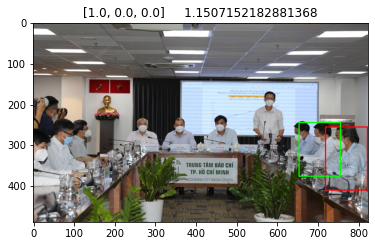

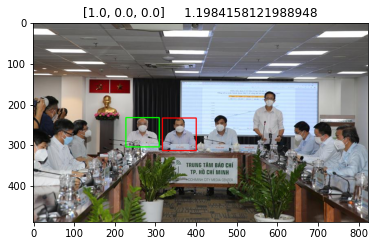

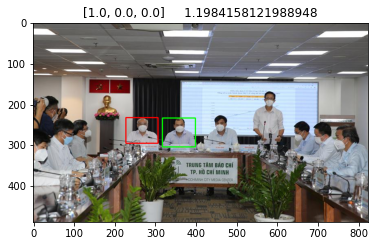

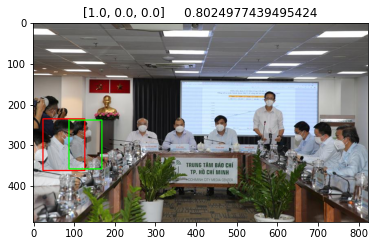

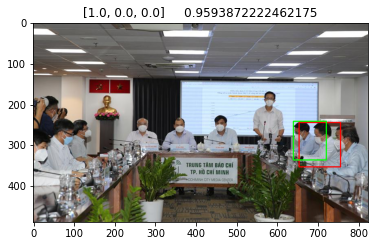

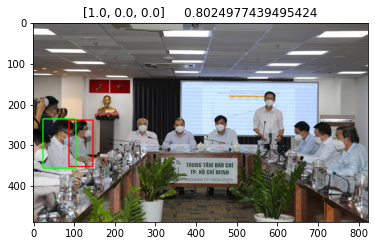

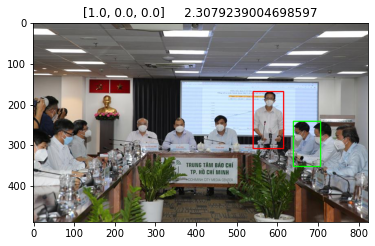

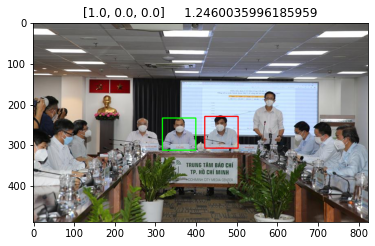

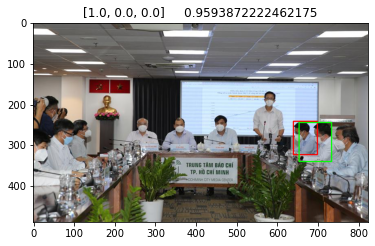

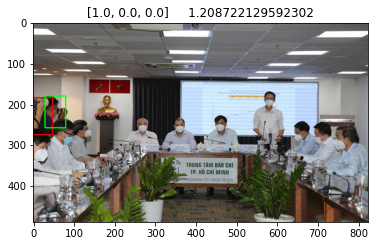

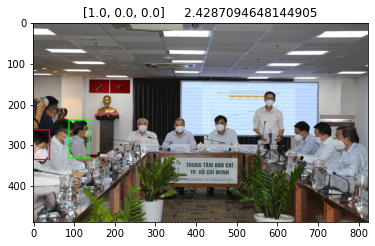

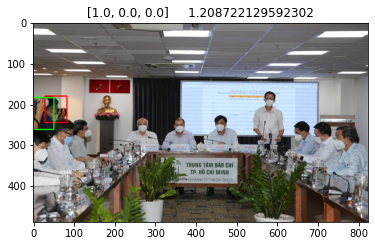

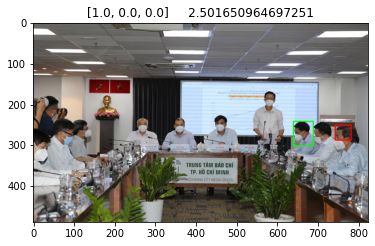

In [22]:
W, H = im.shape[1], im.shape[0]

i = 0
for cx, cy, width, height, dist in zip(cxs, cys, widths, heights, adjusted_distances):
    plt.figure()
    draw = im.copy()
    
    xmin, xmax = int((cx - width / 2)*W), int((cx + width / 2)*W)
    ymin, ymax = int((cy - height / 2)*H), int((cy + height / 2)*H)
    
    cv2.rectangle(draw,(xmin,ymin),(xmax,ymax),(255,0,0),2)
    
    # nearest neighbor 
    if(len(nn_indices) > 1):
        nn_idx = nn_indices[i,1]
        cx1, cy1, width1, height1 = cxs[nn_idx], cys[nn_idx], widths[nn_idx], heights[nn_idx]
        xmin1, xmax1 = int((cx1 - width1 / 2)*W), int((cx1 + width / 2)*W)
        ymin1, ymax1 = int((cy1 - height1 / 2)*H), int((cy1 + height / 2)*H)
        cv2.rectangle(draw, (xmin1,ymin1),(xmax1,ymax1), (0,255,0), 2)

    plt.title(str(ex[['mask', 'distancing', '5k']].tolist()) + '     ' +str(dist))
    plt.imshow(draw)
    
    i+= 1

In [23]:
for i in tqdm(range(len(train_df))):
    ex = train_df.iloc[i]
    path = os.path.join(IM_FOLDER, ex.fname)
    im = plt.imread(path)
    masks = np.load(TRAIN_MASK + '/' + str(ex.image_id) + '.npy')

    cxs, cys, widths, heights, adjusted_distances, nn_indices = get_features(im, masks)
    
    train_df.loc[i, 'nb_max_dist'] = adjusted_distances.max()
    train_df.loc[i, 'nb_min_dist'] = adjusted_distances.min()

  0%|          | 0/3949 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [38]:
train_df.to_csv('../data/train_dist_features.csv', index=False)

In [24]:
for i in tqdm(range(len(test_df))):
    ex = test_df.iloc[i]
    path = os.path.join(PUBLIC_IM_FOLDER, ex.fname)
    im = plt.imread(path)
    masks = np.load(PUBLIC_MASK + '/' + str(ex.image_id) + '.npy')

    cxs, cys, widths, heights, adjusted_distances, nn_indices = get_features(im, masks)
    
    test_df.loc[i, 'nb_max_dist'] = adjusted_distances.max()
    test_df.loc[i, 'nb_min_dist'] = adjusted_distances.min()

  0%|          | 0/542 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [25]:
test_df.to_csv('test_dist_features.csv', index=False)

In [26]:
train_df = pd.read_csv('train_dist_features.csv')

In [27]:
m = RandomForestClassifier()

In [28]:
custom_cross_val_score(m, train_df, ['n_people', 'nb_min_dist', 'nb_max_dist'], 'distancing', thresh=0.5)

[0.5254515599343185,
 0.4697986577181208,
 0.5266666666666666,
 0.4864864864864864,
 0.50814332247557]

In [29]:
# train_df[train_df.distancing==1].nb_min_dist.plot(kind='box', showfliers=False)

In [30]:
# train_df[train_df.distancing==0].nb_min_dist.plot(kind='box', showfliers=False)

In [31]:
# train_df[train_df.distancing==1].nb_max_dist.plot(kind='box', showfliers=False)

In [32]:
# train_df[train_df.distancing==1].nb_max_dist.plot(kind='box', showfliers=False)

In [33]:
m = RandomForestClassifier(n_estimators=10, max_depth=6, random_state=SEED)
custom_cross_val_score(m, train_df, ['n_people', 'nb_min_dist', 'nb_max_dist'], 'distancing', thresh=0.3)

[0.6296715741789354,
 0.610705596107056,
 0.6031746031746033,
 0.618531889290012,
 0.6342592592592593]

In [35]:
X_cols = ['n_people', 'nb_min_dist', 'nb_max_dist']
y_col = 'distancing'
fold_col = 'fold'

folds = np.sort(train_df[fold_col].unique())
scores = []
for f in folds:
    m.fit(train_df.loc[train_df[fold_col]!=f, X_cols], train_df.loc[train_df[fold_col]!=f, y_col])
    pred = m.predict_proba(train_df.loc[train_df[fold_col]==f, X_cols])[:,1]
    train_df.loc[train_df[fold_col]==f, 'prob_dist_ML'] = pred

In [36]:
train_df.to_csv('train_dist_features_prob.csv', index=False)

In [37]:
f1_score(y_pred=train_df[train_df.fold==0]['prob_dist_ML'] >= 0.3, 
         y_true=train_df[train_df.fold==0]['distancing'])

0.6296715741789354

In [ ]:
X_train = train_df.loc[train_df['fold']!=0,['n_people', 'nb_min_dist', 'nb_max_dist']]
y_train = train_df.loc[train_df['fold']!=0, 'distancing']

m.fit(X_train, y_train)
f1_score(y_train, m.predict_proba(X_train)[:,1] >= 0.3)

In [ ]:
X_test = test_df[['n_people', 'nb_min_dist', 'nb_max_dist']]
test_df['prob_dist_ML'] = m.predict_proba(X_test)[:,1]

In [ ]:
test_df.to_csv('test_dist_features_prob.csv', index=False)